In [27]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
np.random.seed(32)
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import make_column_selector
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, precision_recall_curve, auc, f1_score, confusion_matrix, make_scorer, recall_score, precision_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA

In [28]:
with open("train.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

In [29]:
with open("test.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

In [30]:
X_train.head()
len(X_train)

49000

DO WYRZUCENIA

In [31]:
# Custom SmokingImputer (Returns 2D output)
class SmokingImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.distribution_with_never = None
        self.distribution_without_never = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=['smoking_history'])
        self.distribution_without_never = X_df.loc[~X_df['smoking_history'].isin(['No Info', 'never']), 'smoking_history'].value_counts(normalize=True)
        self.distribution_with_never = X_df.loc[~X_df['smoking_history'].isin(['No Info']), 'smoking_history'].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=['smoking_history'])
        mask = X_df['smoking_history'] == 'No Info'
        X_df.loc[mask, 'smoking_history'] = np.random.choice(
            self.distribution_without_never.index, 
            size=mask.sum(), 
            p=self.distribution_without_never.values
        )
        return X_df[['smoking_history']].to_numpy()
    
    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else ['smoking_history']

In [32]:
class ClinicalNotesBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
    
    def fit(self, X, y=None):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        X_cleaned = [x for x in X_cleaned if x]
        self.mlb.fit(X_cleaned)
        return self
    
    def transform(self, X):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        return self.mlb.transform(X_cleaned)
    
    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

In [33]:
def clip_bmi(X):
    X = X.copy()
    X['bmi'] = np.clip(X['bmi'], None, 50)
    return X

In [34]:
# HighCorrelationRemover with preserved feature names
class HighCorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.feature_names_out_ = None
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        corr_matrix = X_df.corr().abs()
        self.to_keep_ = [True] * len(X_df.columns)
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if corr_matrix.iloc[i, j] > self.threshold and self.to_keep_[i]:
                    self.to_keep_[i] = False
        self.feature_names_out_ = [name for name, keep in zip(X_df.columns, self.to_keep_) if keep]
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self.to_keep_]
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

In [61]:
drop_cols = ['year', 'location']
race_cols = [col for col in X_train.columns if col.startswith('race')]
drop_cols.extend(race_cols)

bin_features = ['hypertension', 'heart_disease']
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
cat_features = ['gender']

preprocessor1 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_cols),
        ('scaler', StandardScaler(), num_features),
        #('smokingImputer', SmokingImputer(), ['smoking_history']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

preprocessor2 = ColumnTransformer(
    transformers=[
        ('genderEncoder', OneHotEncoder(categories=[['Male', 'Female']], drop=None, handle_unknown='ignore'), ['remainder__gender']),
        ('smokingEncoder', OneHotEncoder(categories=[['never', 'ever', 'current', 'not current', 'former']], drop=None, handle_unknown='ignore'), ['remainder__smoking_history']),
        ('clinicalNotesBinarizer', ClinicalNotesBinarizer(), ['remainder__clinical_notes']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

pipeline = Pipeline(steps=[
    ('clip_bmi', FunctionTransformer(clip_bmi)),
    ('preprocessor1', preprocessor1),
    ('to_df1', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor1.get_feature_names_out()))),
    ('preprocessor2', preprocessor2),
    ('to_df2', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor2.get_feature_names_out()))),
    ('remove_high_corr', HighCorrelationRemover(threshold=0.95))
])

X_train_transformed = pipeline.fit_transform(X_train)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=pipeline.named_steps['remove_high_corr'].get_feature_names_out())

X_test_transformed = pipeline.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=pipeline.named_steps['remove_high_corr'].get_feature_names_out())

print("Final column names for X_train_transformed_df:")
print(X_train_transformed_df.columns.tolist())
print(X_train_transformed_df.shape[1])

Final column names for X_train_transformed_df:
['genderEncoder__remainder__gender_Male', 'smokingEncoder__remainder__smoking_history_never', 'smokingEncoder__remainder__smoking_history_ever', 'smokingEncoder__remainder__smoking_history_current', 'smokingEncoder__remainder__smoking_history_not current', 'smokingEncoder__remainder__smoking_history_former', 'clinicalNotesBinarizer___advised_dietary_and_exercise_modifications', 'clinicalNotesBinarizer___cardiac_condition_present', 'clinicalNotesBinarizer___consideration_for_metabolic_syndrome_and_type_2_diabetes', 'clinicalNotesBinarizer___elderly_patient_with_increased_risk_of_chronic_conditions', 'clinicalNotesBinarizer___elevated_blood_glucose_levels', 'clinicalNotesBinarizer___generally_lower_risk_but_needs_lifestyle_assessment', 'clinicalNotesBinarizer___healthy_bmi_range', 'clinicalNotesBinarizer___high_hba1c_level', 'clinicalNotesBinarizer___higher_predisposition_to_hypertension_and_diabetes', 'clinicalNotesBinarizer___history_of_hy

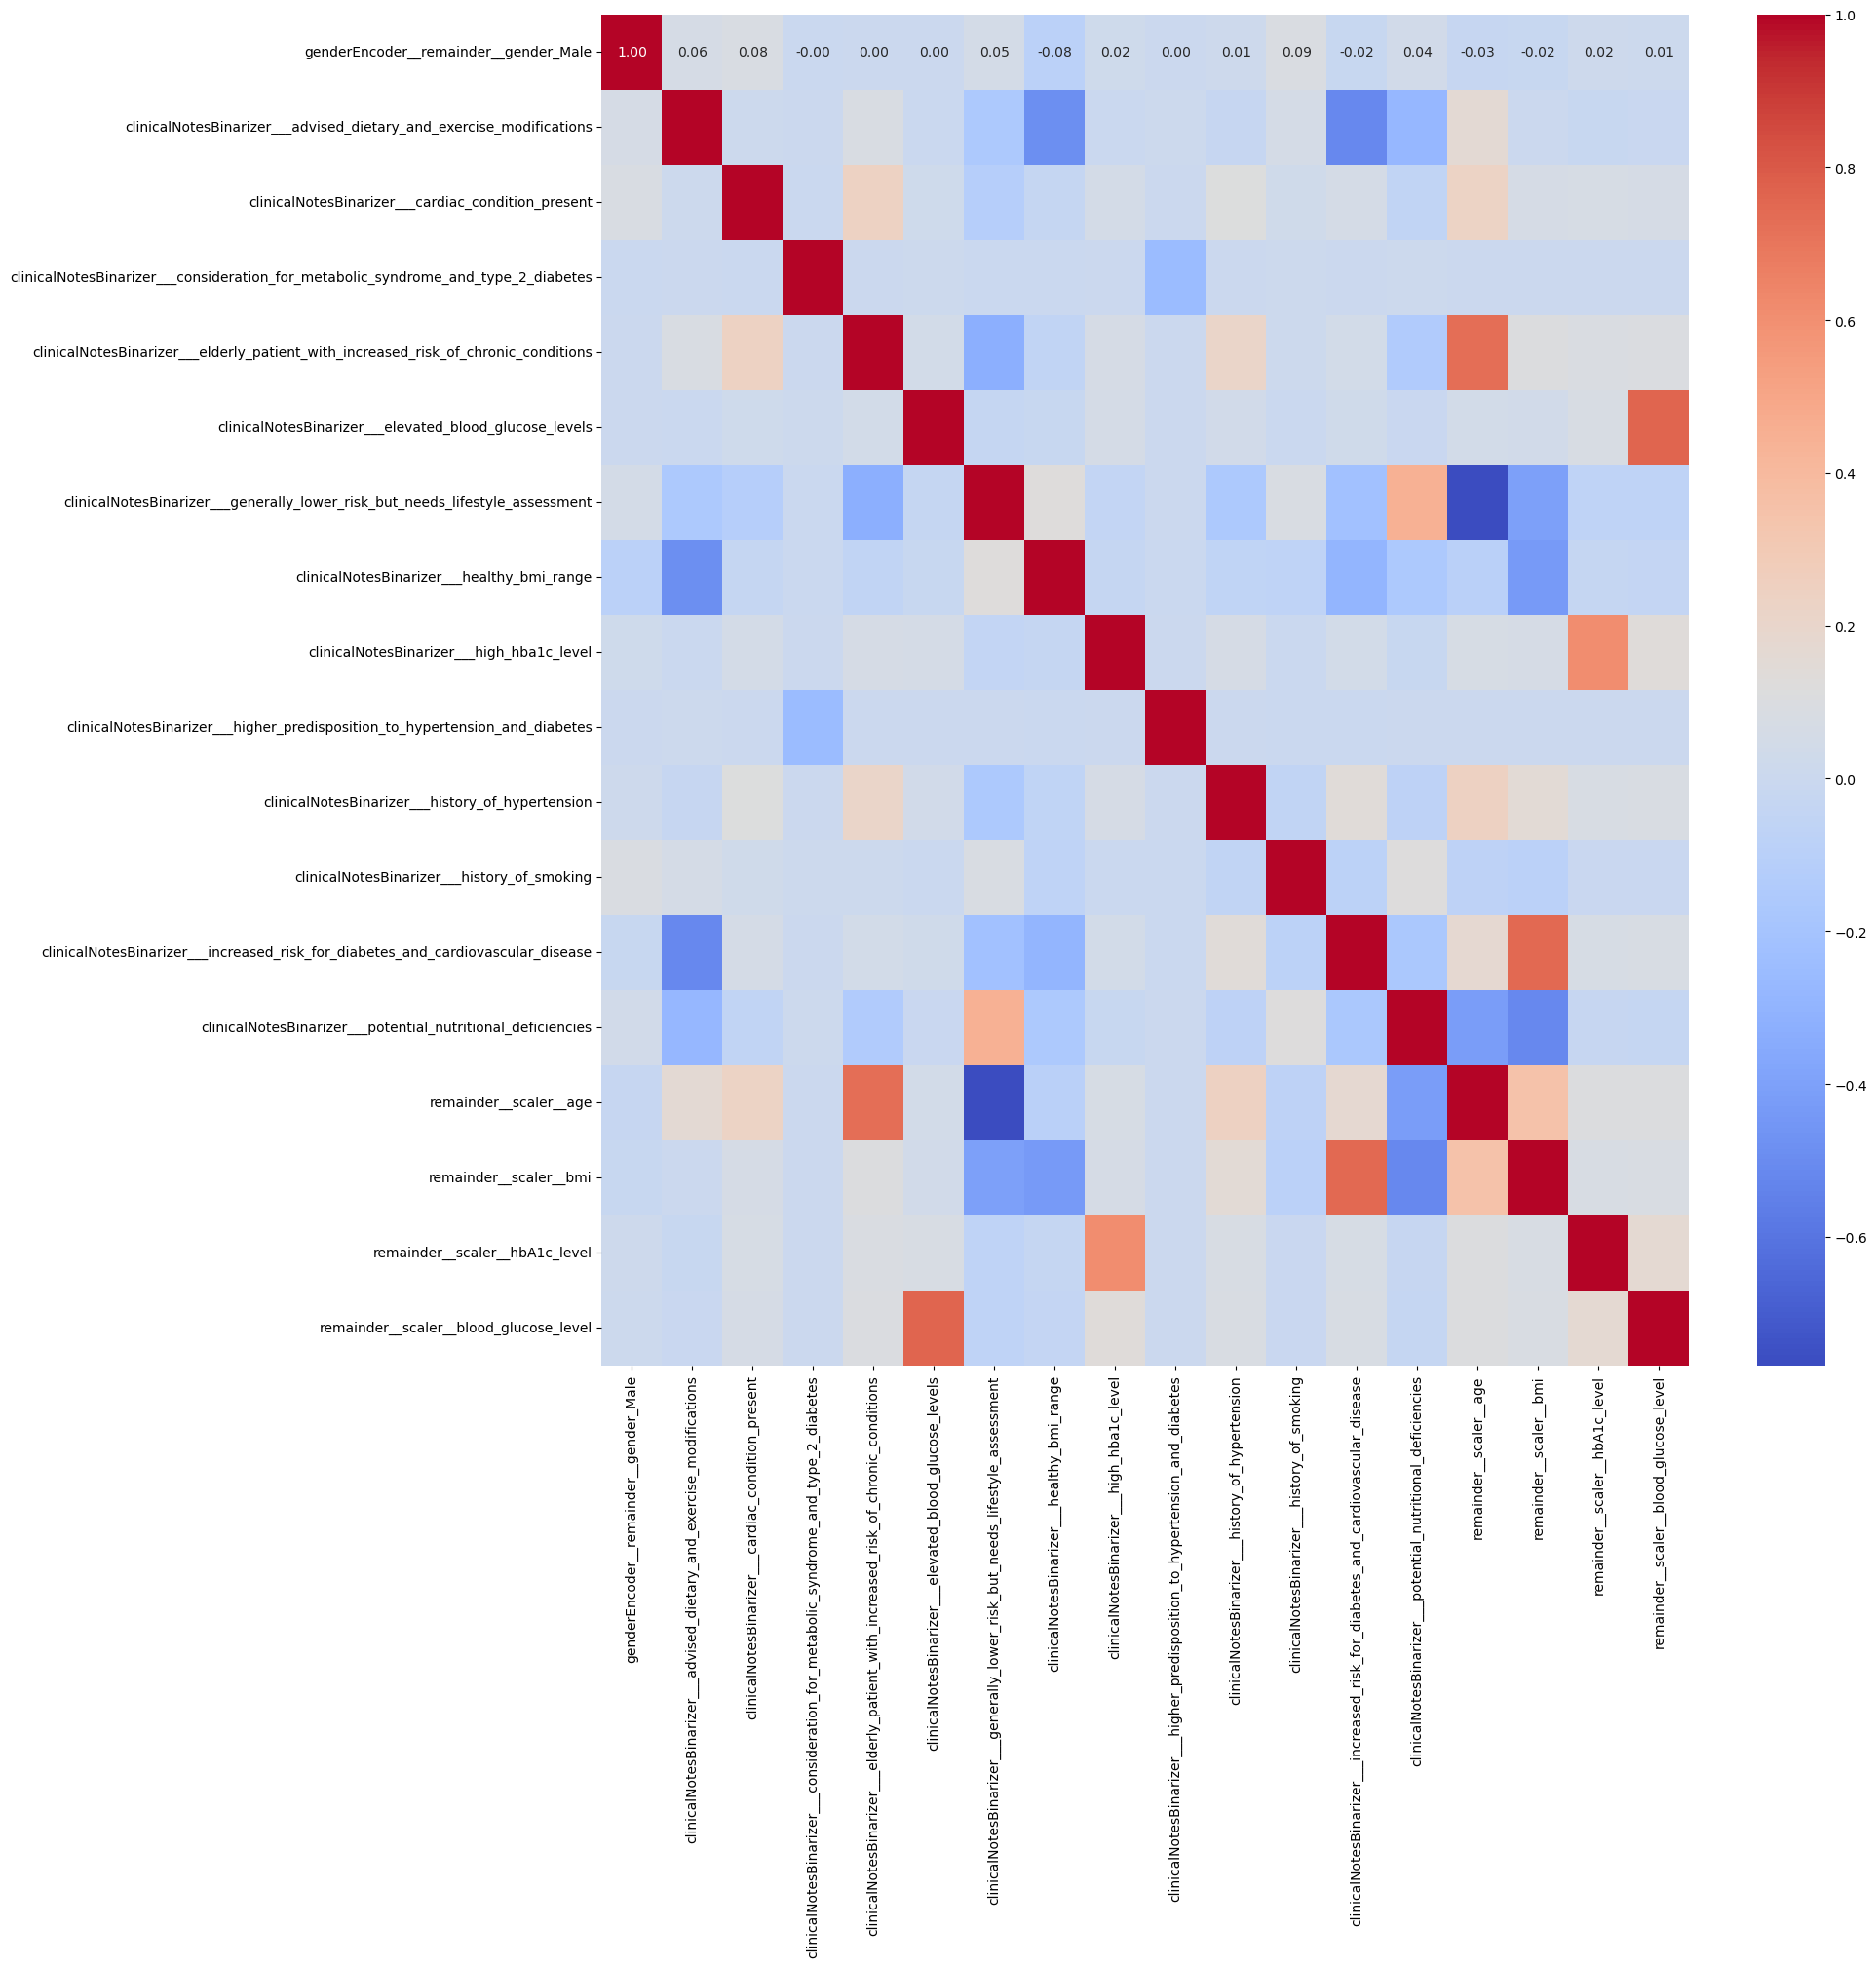

In [36]:
plt.figure(figsize=(18, 18))
sns.heatmap(X_train_transformed_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [37]:
def scores_model(X_train_transformed_df, X_test_transformed_df, model):
    model.fit(X_train_transformed_df, y_train)
    
    # Predictions and probabilities
    y_train_pred = model.predict(X_train_transformed_df)
    y_test_pred = model.predict(X_test_transformed_df)
    y_train_scores = model.predict_proba(X_train_transformed_df)[:, 1]  # Probabilities for training
    y_test_scores = model.predict_proba(X_test_transformed_df)[:, 1]   # Probabilities for test
    
    # Precision-Recall Curves
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)
    
    # Evaluate the model
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    train_pr_auc = auc(recall_train, precision_train)  # PR-AUC for training
    test_pr_auc = auc(recall_test, precision_test)     # PR-AUC for test
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    train_prec = accuracy_score(y_train, y_train_pred)
    test_prec = accuracy_score(y_test, y_test_pred)
    cfm = confusion_matrix(y_test, y_test_pred)
    
    # Print results
    print("\nModel Performance:")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Training PR-AUC: {train_pr_auc:.4f}")
    print(f"Test PR-AUC: {test_pr_auc:.4f}")
    print(f"Training Accuracy Score: {train_prec:.4f}")
    print(f"Test Accuracy Score: {test_prec:.4f}")
    print(f"Training Recall Score: {train_recall:.4f}")
    print(f"Test Recall Score: {test_recall:.4f}")
    print("Test Confusion Matrix:\n", cfm)
    disp = ConfusionMatrixDisplay(cfm)
    disp.plot()
    plt.show()
    return (train_roc_auc, test_roc_auc, train_pr_auc, test_pr_auc)


Model Performance:
Training ROC-AUC: 0.8091
Test ROC-AUC: 0.8146
Training PR-AUC: 0.8225
Test PR-AUC: 0.8298
Training F1 Score: 0.7326
Test F1 Score: 0.7422
Training Accuracy Score: 0.9612
Test Accuracy Score: 0.9624
Training Recall Score: 0.6259
Test Recall Score: 0.6364
Test Confusion Matrix:
 [[19075   140]
 [  649  1136]]


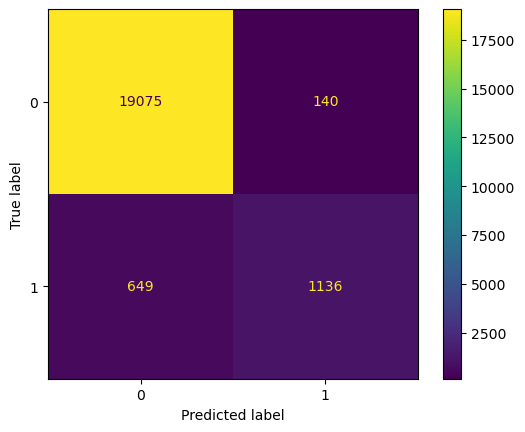

(0.8091177454588393,
 0.8145642956636205,
 0.8225178430929135,
 0.8297629259174204,
 0.732612055641422,
 0.7422410976804966)

In [38]:
model = LogisticRegression()
scores_model(X_train_transformed_df, X_test_transformed_df, model)


Model Performance:
Training ROC-AUC: 0.8883
Test ROC-AUC: 0.8901
Training PR-AUC: 0.8203
Test PR-AUC: 0.8277
Training F1 Score: 0.5720
Test F1 Score: 0.5688
Training Accuracy Score: 0.8868
Test Accuracy Score: 0.8844
Training Recall Score: 0.8900
Test Recall Score: 0.8969
Test Confusion Matrix:
 [[16972  2243]
 [  184  1601]]


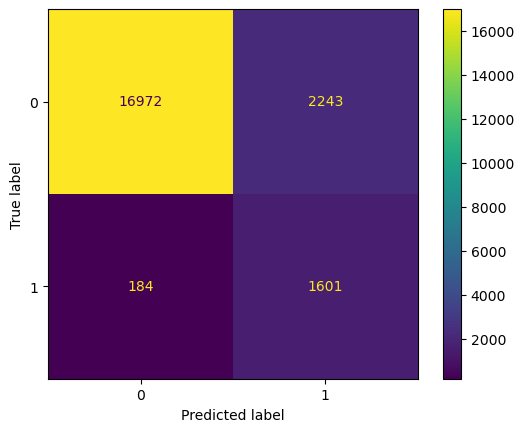

(0.888265470122475,
 0.8900935237482971,
 0.8202767716081721,
 0.8277131314375978,
 0.5720237635984877,
 0.5688399360454788)

In [39]:
model = LogisticRegression(class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, model)

In [40]:
sel = SelectKBest(f_classif, k=15)
X_train_sel = sel.fit_transform(X_train_transformed_df, y_train)
X_test_sel = sel.transform(X_test_transformed_df)

columns = X_train_transformed_df.columns.tolist()
selected_columns = np.array(columns)[sel.get_support()].tolist()

print("Selected features:", selected_columns)

Selected features: ['genderEncoder__remainder__gender_Male', 'clinicalNotesBinarizer___advised_dietary_and_exercise_modifications', 'clinicalNotesBinarizer___cardiac_condition_present', 'clinicalNotesBinarizer___elderly_patient_with_increased_risk_of_chronic_conditions', 'clinicalNotesBinarizer___elevated_blood_glucose_levels', 'clinicalNotesBinarizer___generally_lower_risk_but_needs_lifestyle_assessment', 'clinicalNotesBinarizer___healthy_bmi_range', 'clinicalNotesBinarizer___high_hba1c_level', 'clinicalNotesBinarizer___history_of_hypertension', 'clinicalNotesBinarizer___increased_risk_for_diabetes_and_cardiovascular_disease', 'clinicalNotesBinarizer___potential_nutritional_deficiencies', 'remainder__scaler__age', 'remainder__scaler__bmi', 'remainder__scaler__hbA1c_level', 'remainder__scaler__blood_glucose_level']



Model Performance:
Training ROC-AUC: 0.8878
Test ROC-AUC: 0.8903
Training PR-AUC: 0.8200
Test PR-AUC: 0.8276
Training F1 Score: 0.5711
Test F1 Score: 0.5690
Training Accuracy Score: 0.8864
Test Accuracy Score: 0.8844
Training Recall Score: 0.8896
Test Recall Score: 0.8975
Test Confusion Matrix:
 [[16971  2244]
 [  183  1602]]


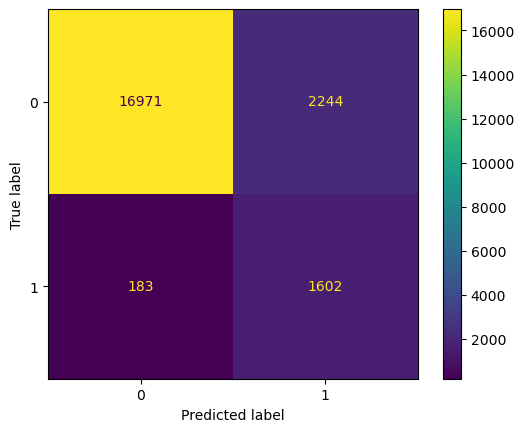

(0.8878357900537265,
 0.8903476144556183,
 0.8200225105843301,
 0.8276024111393911,
 0.5710542540073983,
 0.5689930740543421)

In [41]:
model = LogisticRegression(class_weight='balanced')
scores_model(X_train_sel, X_test_sel, model)


Model Performance:
Training ROC-AUC: 0.8883
Test ROC-AUC: 0.8900
Training PR-AUC: 0.8203
Test PR-AUC: 0.8278
Training F1 Score: 0.5719
Test F1 Score: 0.5686
Training Accuracy Score: 0.8867
Test Accuracy Score: 0.8843
Training Recall Score: 0.8903
Test Recall Score: 0.8969
Test Confusion Matrix:
 [[16970  2245]
 [  184  1601]]


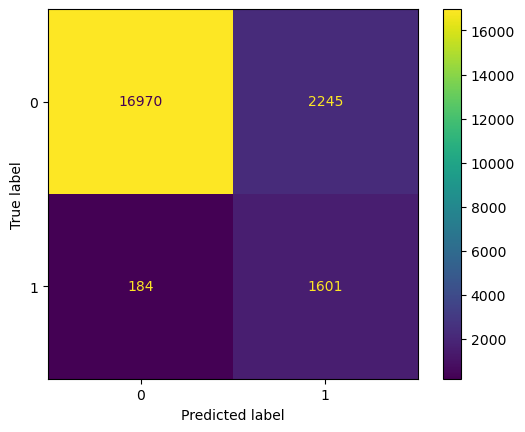

(0.8883297581327613,
 0.8900414810733036,
 0.8203382532113278,
 0.8277677274756706,
 0.5719133184236909,
 0.5686378973539336)

In [42]:
model = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, model)

Fitting estimator with 18 features.
Fitting estimator with 17 features.

Model Performance:
Training ROC-AUC: 0.8884
Test ROC-AUC: 0.8897
Training PR-AUC: 0.8203
Test PR-AUC: 0.8278
Training F1 Score: 0.5720
Test F1 Score: 0.5682
Training Accuracy Score: 0.8868
Test Accuracy Score: 0.8842
Training Recall Score: 0.8903
Test Recall Score: 0.8964
Test Confusion Matrix:
 [[16968  2247]
 [  185  1600]]


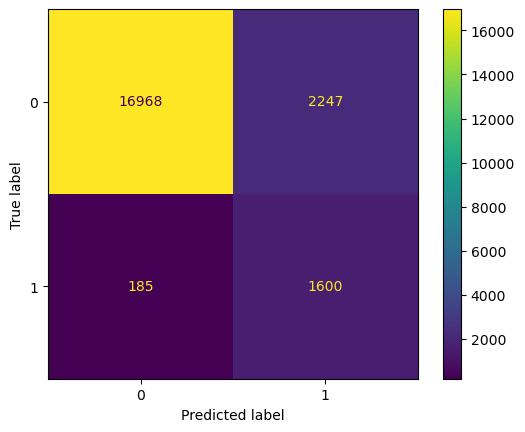

(0.88835206213633,
 0.8897093263534922,
 0.8203492708397274,
 0.8277679625293756,
 0.572001542614732,
 0.5681818181818182)

In [43]:
rfe = RFE(estimator = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced'), n_features_to_select=16, verbose=1)
scores_model(X_train_transformed_df, X_test_transformed_df, rfe)


Model Performance:
Training ROC-AUC: 0.8832
Test ROC-AUC: 0.8874
Training PR-AUC: 0.8148
Test PR-AUC: 0.8214
Training F1 Score: 0.5581
Test F1 Score: 0.5595
Training Accuracy Score: 0.8807
Test Accuracy Score: 0.8800
Training Recall Score: 0.8862
Test Recall Score: 0.8964
Test Confusion Matrix:
 [[16881  2334]
 [  185  1600]]


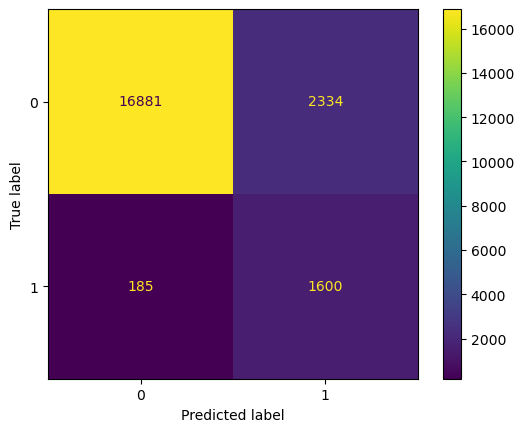

(0.8831886853101897,
 0.8874454699912752,
 0.8148372308543138,
 0.8214074639990095,
 0.5580586634411854,
 0.5595383808358104)

In [44]:
X_train_transformed_df.var()
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train_transformed_df)
mask = sel.get_support()
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
model = LogisticRegression(class_weight='balanced')
scores_model(X_train_sel, X_test_sel, model)


The results with Variance Treshold are worse than only Logistic Regression


Model Performance:
Training ROC-AUC: 0.8068
Test ROC-AUC: 0.7909
Training PR-AUC: 0.8906
Test PR-AUC: 0.8060
Training F1 Score: 0.7479
Test F1 Score: 0.7187
Training Accuracy Score: 0.9647
Test Accuracy Score: 0.9610
Training Recall Score: 0.6166
Test Recall Score: 0.5860
Test Confusion Matrix:
 [[19135    80]
 [  739  1046]]


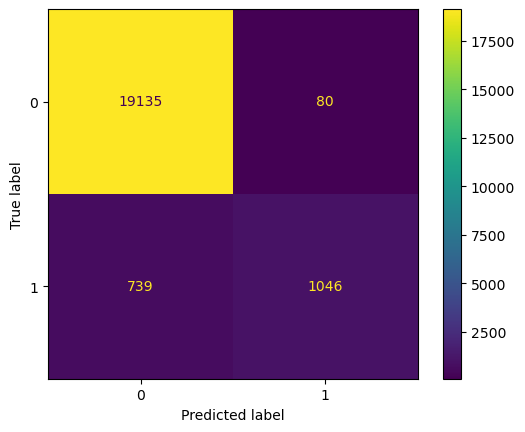

(0.8067889450862312,
 0.790915491879812,
 0.8905525748002239,
 0.8060320237391485,
 0.7479248580166011,
 0.7186533837169358)

In [47]:
model = KNeighborsClassifier(n_neighbors = 7)
scores_model(X_train_transformed_df, X_test_transformed_df, model)

RandomisedSearchCV for DecisionTreeClassifier

Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 0.2, 'max_features': 4, 'max_depth': 11, 'criterion': 'gini'}

Best model scores:

Model Performance:
Training ROC-AUC: 0.7830
Test ROC-AUC: 0.7834
Training PR-AUC: 0.5646
Test PR-AUC: 0.5637
Training F1 Score: 0.3192
Test F1 Score: 0.3207
Training Accuracy Score: 0.6641
Test Accuracy Score: 0.6678
Training Recall Score: 0.9263
Test Recall Score: 0.9227
Test Confusion Matrix:
 [[12377  6838]
 [  138  1647]]


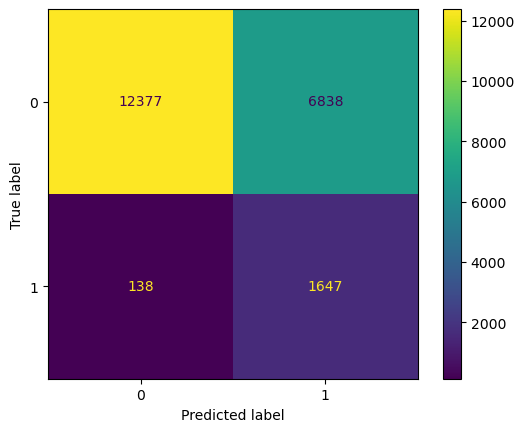

(0.7830069732811158,
 0.7834106320123678,
 0.5645832906664481,
 0.5637115763038807,
 0.3191594970218398,
 0.32074001947419667)

In [48]:
def pr_auc_scorer(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)
    
param_dist = {
    "max_depth" : range(2, 20),
    "max_features" : range(2, 10),
    "min_samples_split" : range(2, 20),
    'min_samples_leaf': [0.05, 0.1, 0.15, 0.2],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(class_weight='balanced')
scoring = {
    'roc_auc': 'roc_auc', 
    'f1_score': 'f1',  
    'pr_auc': make_scorer(pr_auc_scorer),
    'recall': 'recall' 
}

random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scoring, random_state=42, n_jobs=-1, refit='recall')

random_search.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search.best_params_)

best_model = random_search.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, best_model)


Model Performance:
Training ROC-AUC: 0.8083
Test ROC-AUC: 0.8074
Training PR-AUC: 0.5135
Test PR-AUC: 0.5057
Training F1 Score: 0.3717
Test F1 Score: 0.3724
Training Accuracy Score: 0.7462
Test Accuracy Score: 0.7484
Training Recall Score: 0.8831
Test Recall Score: 0.8784
Test Confusion Matrix:
 [[14148  5067]
 [  217  1568]]


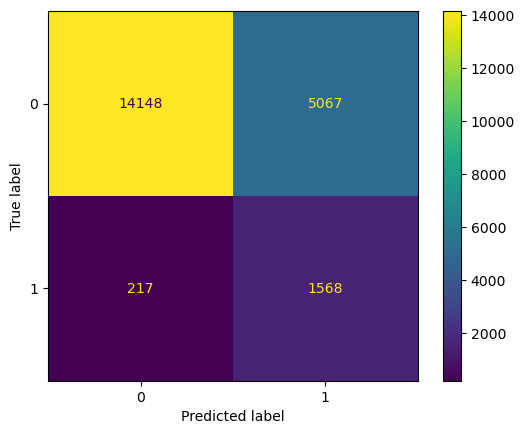

In [49]:
lr = LogisticRegression(class_weight='balanced')

knn = KNeighborsClassifier(n_neighbors=9)

dt = DecisionTreeClassifier(max_depth = 15, min_samples_leaf=0.1, random_state=2, max_features = 15, class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, dt)

classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

Voting Classifier

Logistic Regression

Model Performance:
Training ROC-AUC: 0.8883
Test ROC-AUC: 0.8901
Training PR-AUC: 0.8203
Test PR-AUC: 0.8277
Training F1 Score: 0.5720
Test F1 Score: 0.5688
Training Accuracy Score: 0.8868
Test Accuracy Score: 0.8844
Training Recall Score: 0.8900
Test Recall Score: 0.8969
Test Confusion Matrix:
 [[16972  2243]
 [  184  1601]]


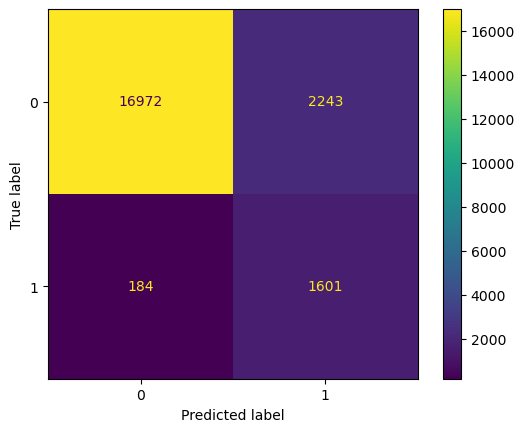

K Nearest Neighbours

Model Performance:
Training ROC-AUC: 0.7977
Test ROC-AUC: 0.7891
Training PR-AUC: 0.8791
Test PR-AUC: 0.8105
Training F1 Score: 0.7368
Test F1 Score: 0.7191
Training Accuracy Score: 0.9637
Test Accuracy Score: 0.9614
Training Recall Score: 0.5976
Test Recall Score: 0.5815
Test Confusion Matrix:
 [[19151    64]
 [  747  1038]]


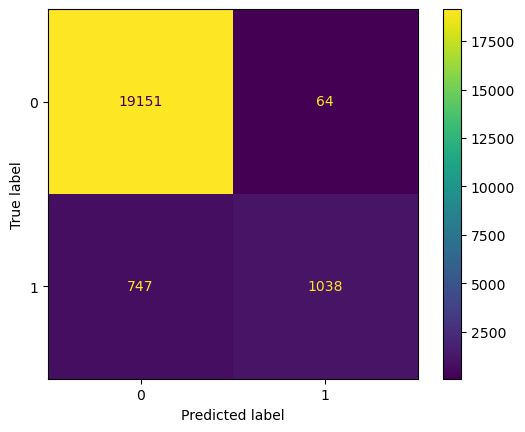

Classification Tree

Model Performance:
Training ROC-AUC: 0.8083
Test ROC-AUC: 0.8074
Training PR-AUC: 0.5135
Test PR-AUC: 0.5057
Training F1 Score: 0.3717
Test F1 Score: 0.3724
Training Accuracy Score: 0.7462
Test Accuracy Score: 0.7484
Training Recall Score: 0.8831
Test Recall Score: 0.8784
Test Confusion Matrix:
 [[14148  5067]
 [  217  1568]]


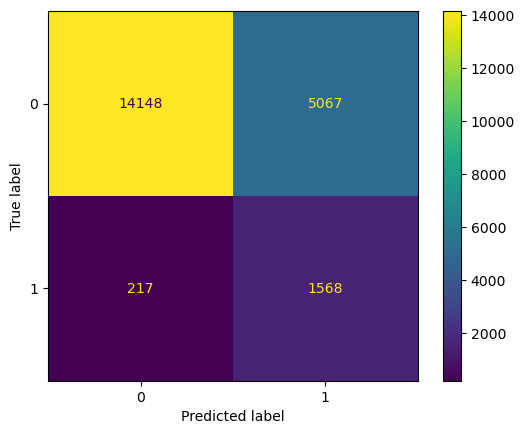

Voting classifier:

Model Performance:
Training ROC-AUC: 0.8890
Test ROC-AUC: 0.8812
Training PR-AUC: 0.8473
Test PR-AUC: 0.8289
Training F1 Score: 0.6710
Test F1 Score: 0.6599
Training Accuracy Score: 0.9300
Test Accuracy Score: 0.9277
Training Recall Score: 0.8396
Test Recall Score: 0.8252
Test Confusion Matrix:
 [[18009  1206]
 [  312  1473]]


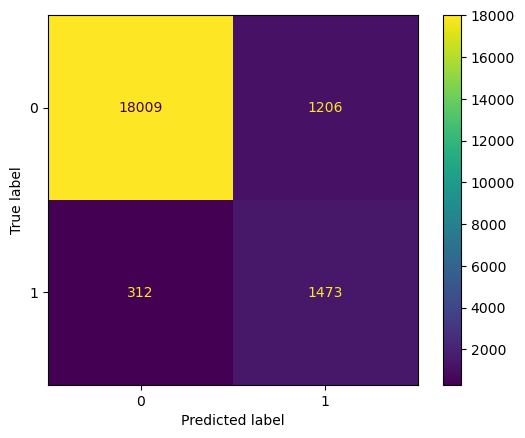

(0.8890172462427594,
 0.8812233089957295,
 0.8473464036094621,
 0.8288744163104925,
 0.6710160222584669,
 0.6599462365591398)

In [50]:
for clf_name, model in classifiers:    
    print(clf_name)
    scores_model(X_train_transformed_df, X_test_transformed_df, model)
vc = VotingClassifier(estimators=classifiers, voting='soft') 
print('Voting classifier:')
scores_model(X_train_transformed_df, X_test_transformed_df, vc)

Random Forest Classifier


Model Performance:
Training ROC-AUC: 0.9385
Test ROC-AUC: 0.9031
Training PR-AUC: 0.9326
Test PR-AUC: 0.8799
Training F1 Score: 0.7156
Test F1 Score: 0.6701
Training Accuracy Score: 0.9364
Test Accuracy Score: 0.9268
Training Recall Score: 0.9409
Test Recall Score: 0.8745
Test Confusion Matrix:
 [[17902  1313]
 [  224  1561]]


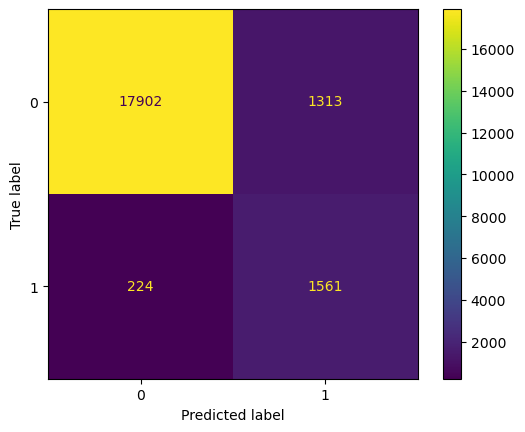

(0.938473094155695,
 0.9030888858275551,
 0.9326324399713616,
 0.8799334946377787,
 0.7156030311330229,
 0.670100880017171)

In [51]:
rf = RandomForestClassifier(max_depth=13, class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, rf)


Model Performance:
Training ROC-AUC: 0.9351
Test ROC-AUC: 0.9027
Training PR-AUC: 0.9288
Test PR-AUC: 0.8788
Training F1 Score: 0.7006
Test F1 Score: 0.6570
Training Accuracy Score: 0.9318
Test Accuracy Score: 0.9220
Training Recall Score: 0.9390
Test Recall Score: 0.8796
Test Confusion Matrix:
 [[17791  1424]
 [  215  1570]]


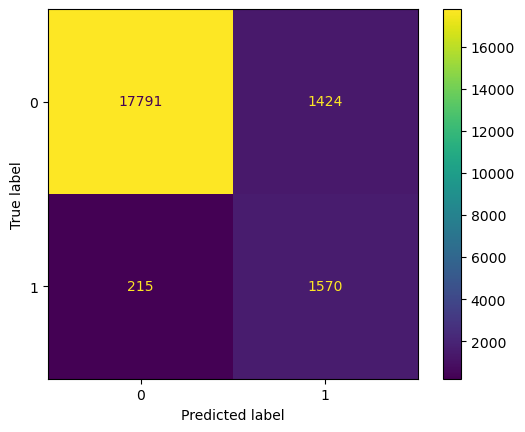

(0.9350592696094832,
 0.9027215257687775,
 0.928793808230248,
 0.8787679802831491,
 0.7005821764442454,
 0.6570412220129734)

In [52]:
sel = SelectKBest(f_classif, k=15)
X_train_sel = sel.fit_transform(X_train_transformed_df, y_train)
X_test_sel = sel.transform(X_test_transformed_df)
scores_model(X_train_sel, X_test_sel, rf)


Model Performance:
Training ROC-AUC: 0.9409
Test ROC-AUC: 0.8999
Training PR-AUC: 0.9317
Test PR-AUC: 0.8790
Training F1 Score: 0.7229
Test F1 Score: 0.6688
Training Accuracy Score: 0.9385
Test Accuracy Score: 0.9270
Training Recall Score: 0.9438
Test Recall Score: 0.8672
Test Confusion Matrix:
 [[17919  1296]
 [  237  1548]]


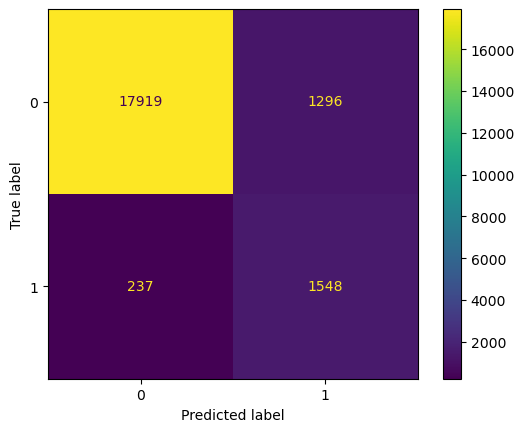

(0.9409173505467762,
 0.8998897919823667,
 0.9316808974090292,
 0.8789520289885513,
 0.7229425287356321,
 0.6688269604666235)

In [53]:
X_train_transformed_df.var()
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train_transformed_df)
mask = sel.get_support()
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
scores_model(X_train_sel, X_test_sel, rf)


Model Performance:
Training ROC-AUC: 0.9393
Test ROC-AUC: 0.9018
Training PR-AUC: 0.9322
Test PR-AUC: 0.8796
Training F1 Score: 0.7177
Test F1 Score: 0.6668
Training Accuracy Score: 0.9370
Test Accuracy Score: 0.9259
Training Recall Score: 0.9421
Test Recall Score: 0.8728
Test Confusion Matrix:
 [[17885  1330]
 [  227  1558]]


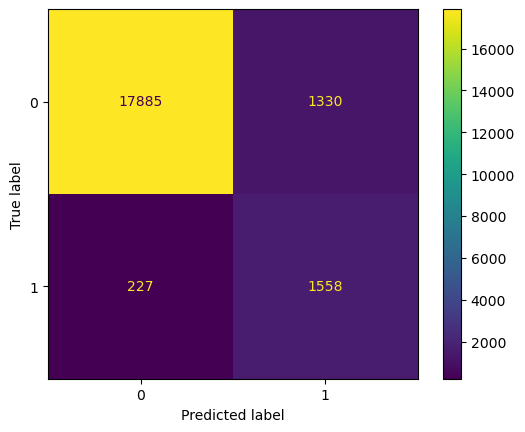

[0.0049027  0.0033175  0.0079509  0.00353222 0.03397763 0.05086106
 0.02991837 0.00364939 0.08874843 0.00335465 0.01277482 0.00425262
 0.02258818 0.00279339 0.1194398  0.05593616 0.31311717 0.238885  ]

Model Performance:
Training ROC-AUC: 0.9211
Test ROC-AUC: 0.8947
Training PR-AUC: 0.8932
Test PR-AUC: 0.8608
Training F1 Score: 0.6367
Test F1 Score: 0.6013
Training Accuracy Score: 0.9092
Test Accuracy Score: 0.8999
Training Recall Score: 0.9354
Test Recall Score: 0.8885
Test Confusion Matrix:
 [[17311  1904]
 [  199  1586]]


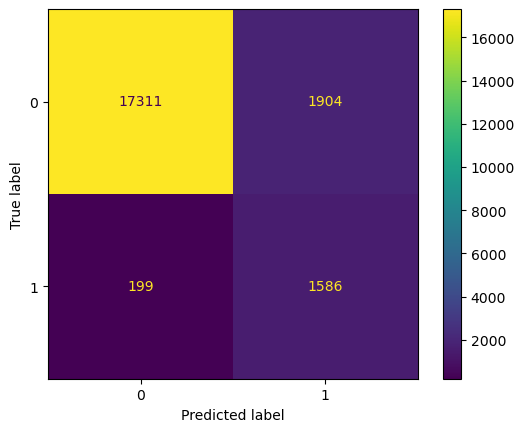

(0.9211140193782431,
 0.8947130764874256,
 0.8932279582830844,
 0.8608319916427879,
 0.6366533213497835,
 0.6013270142180095)

In [54]:
scores_model(X_train_transformed_df, X_test_transformed_df, rf)
print(rf.feature_importances_)
mask = rf.feature_importances_ > 0.06
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
scores_model(X_train_sel, X_test_sel, rf)

Fitting estimator with 18 features.
Fitting estimator with 13 features.

Model Performance:
Training ROC-AUC: 0.9414
Test ROC-AUC: 0.8995
Training PR-AUC: 0.9326
Test PR-AUC: 0.8776
Training F1 Score: 0.7248
Test F1 Score: 0.6678
Training Accuracy Score: 0.9391
Test Accuracy Score: 0.9267
Training Recall Score: 0.9443
Test Recall Score: 0.8667
Test Confusion Matrix:
 [[17914  1301]
 [  238  1547]]


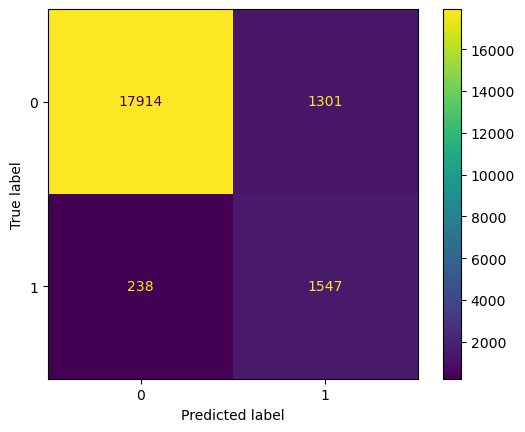

(0.9414362466297994,
 0.899479573250065,
 0.9325676147860434,
 0.8776062194756913,
 0.7248433468485072,
 0.6678178286207641)

In [55]:
rfe = RFE(estimator=rf, n_features_to_select=8, verbose=1, step=5)
scores_model(X_train_transformed_df, X_test_transformed_df, rfe)

[0.27058047 0.45777669 0.60327681 0.73046027 0.78523114 0.82481308
 0.85824209 0.88981615 0.91239158 0.93131831 0.94744178 0.96269949
 0.97591746 0.98578394 0.99120428 0.9961427  1.         1.        ]


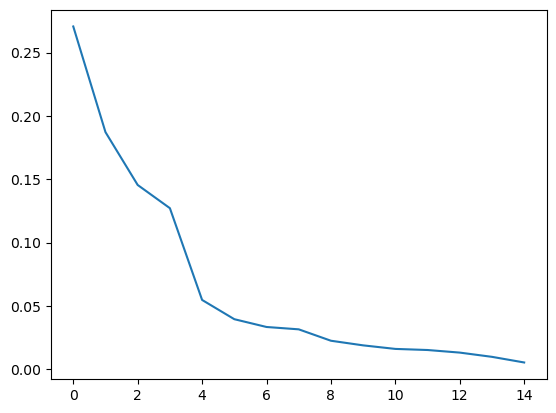

In [56]:
pipelinePCA = Pipeline([
    ('reducer', PCA(n_components=15)),
    ('classifier', rf)
])
pca = PCA()
pca.fit_transform(X_train_transformed_df, y_train)
print(pca.explained_variance_ratio_.cumsum())
pipelinePCA.fit(X_train_transformed, y_train)
plt.plot(pipelinePCA['reducer'].explained_variance_ratio_)


Model Performance:
Training ROC-AUC: 0.9538
Test ROC-AUC: 0.8852
Training PR-AUC: 0.9374
Test PR-AUC: 0.8468
Training F1 Score: 0.7750
Test F1 Score: 0.6804
Training Accuracy Score: 0.9529
Test Accuracy Score: 0.9340
Training Recall Score: 0.9549
Test Recall Score: 0.8263
Test Confusion Matrix:
 [[18139  1076]
 [  310  1475]]


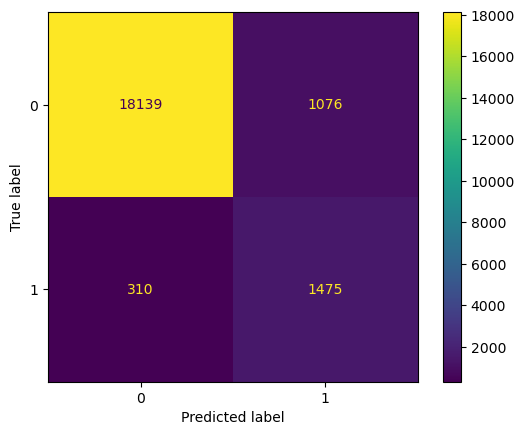

(0.9537775766044122,
 0.8851663069599424,
 0.9373781392120379,
 0.8467782322406416,
 0.7750170515443827,
 0.6803505535055351)

In [62]:
pipelinePCA2 = Pipeline([
    ('reducer', PCA(n_components=5)),
    ('classifier', rf)
])
scores_model(X_train_transformed_df, X_test_transformed_df, pipelinePCA2)

Best parameters: {'n_estimators': 22, 'min_samples_split': 7, 'max_features': 9, 'max_depth': 8}

Best model scores:

Model Performance:
Training ROC-AUC: 0.9064
Test ROC-AUC: 0.9067
Training PR-AUC: 0.8795
Test PR-AUC: 0.8853
Training F1 Score: 0.5837
Test F1 Score: 0.5832
Training Accuracy Score: 0.8873
Test Accuracy Score: 0.8870
Training Recall Score: 0.9294
Test Recall Score: 0.9305
Test Confusion Matrix:
 [[16965  2250]
 [  124  1661]]


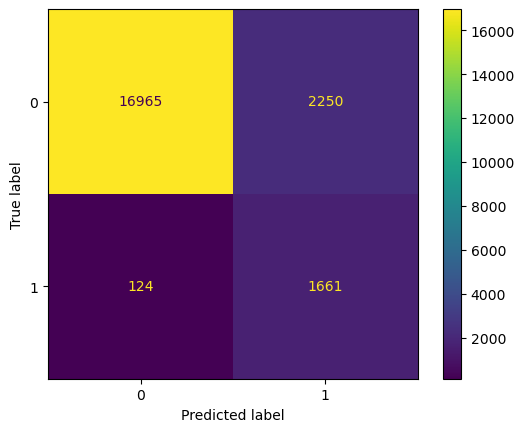

(0.906414369026299,
 0.9067180970748955,
 0.8794803562549268,
 0.8852978132998236,
 0.5837291713790244,
 0.5832162921348315)

In [58]:
param_dist = {"max_depth" : range(2, 20),
              "max_features" : range(2, 10),
              "min_samples_split" : range(2, 20),
              "n_estimators" : range(2, 100, 10)}

scorer = make_scorer(recall_score)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scorer)

random_search.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search.best_params_)

best_model = random_search.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, best_model)


Model Performance:
Training ROC-AUC: 0.9063
Test ROC-AUC: 0.9066
Training PR-AUC: 0.8793
Test PR-AUC: 0.8854
Training F1 Score: 0.5896
Test F1 Score: 0.5889
Training Accuracy Score: 0.8905
Test Accuracy Score: 0.8900
Training Recall Score: 0.9253
Test Recall Score: 0.9266
Test Confusion Matrix:
 [[17037  2178]
 [  131  1654]]


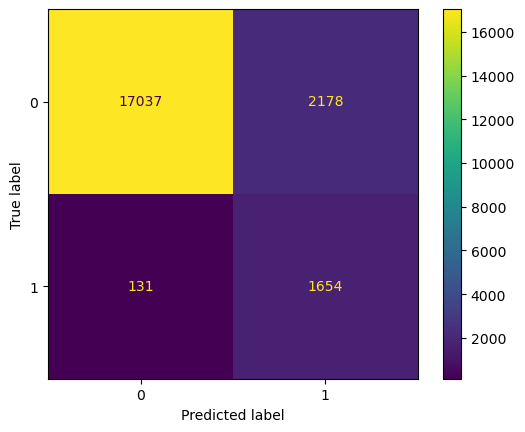

(0.9062916970066714,
 0.9066308490609359,
 0.879258803691494,
 0.8854130861500803,
 0.5895670797001683,
 0.588926473206338)

In [59]:
clf = BaggingClassifier(estimator=best_model,
                        n_estimators=15)
scores_model(X_train_transformed_df, X_test_transformed_df, clf)


Model Performance:
Training ROC-AUC: 0.8319
Test ROC-AUC: 0.8465
Training PR-AUC: 0.8679
Test PR-AUC: 0.8773
Training F1 Score: 0.7980
Test F1 Score: 0.8187
Training Accuracy Score: 0.9714
Test Accuracy Score: 0.9739
Training Recall Score: 0.6639
Test Recall Score: 0.6930
Test Confusion Matrix:
 [[19215     0]
 [  548  1237]]


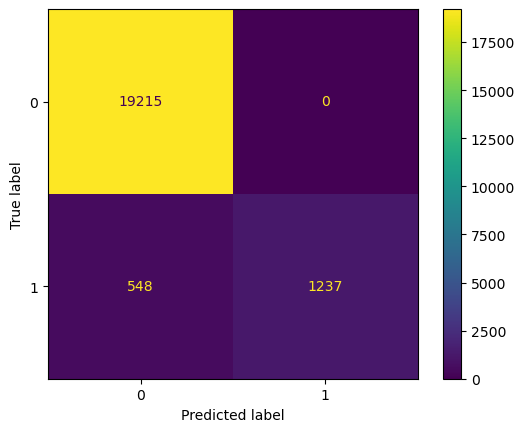

(0.8319327731092436,
 0.8464985994397759,
 0.8679404059139555,
 0.8773173872150284,
 0.797979797979798,
 0.8186631369953673)

In [60]:
ada = AdaBoostClassifier()
scores_model(X_train_transformed_df, X_test_transformed_df, ada)